In [120]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [121]:
models = {
    "GloVe": "baseline",
    "ConvS2S": "fairseq.wmt14.en-fr.fconv",
    "InferSent": "infersent.allnli",
    "IMDB": "imdbsentiment",
    "skipthought": "skipthought",
    "DisSent": "dissent.books8.epoch9",
    "order": "order-embeddings",
    "ELMo": "elmo.2x4096",
    "BERT": "bert.base",
    "openai": "transformer.roc",
}

In [122]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    plt.title("%s: Within-subject MAR" % name)
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(level=0, drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="%s: Within-subject MAR" % name)
    
    return subj_perf

In [123]:
stats = {}

--------

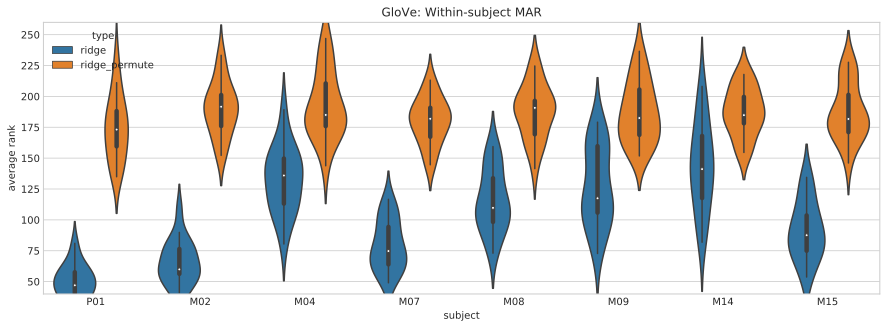

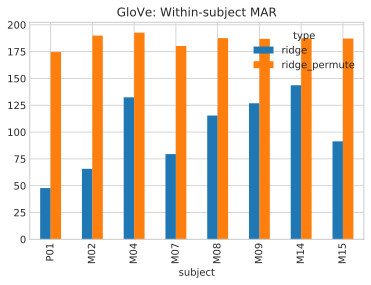

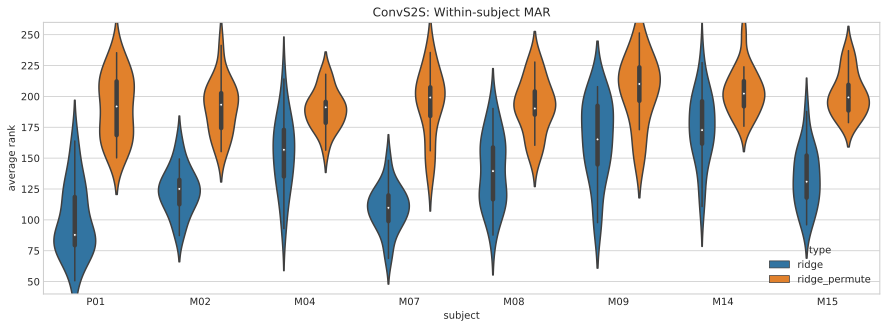

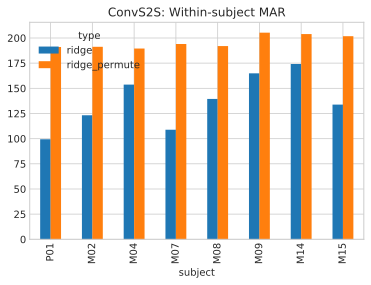

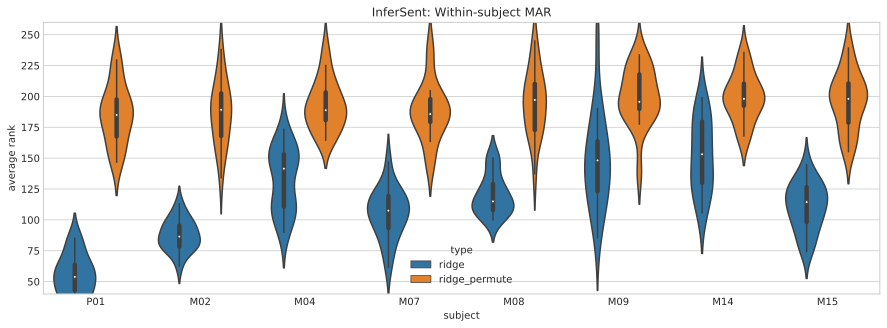

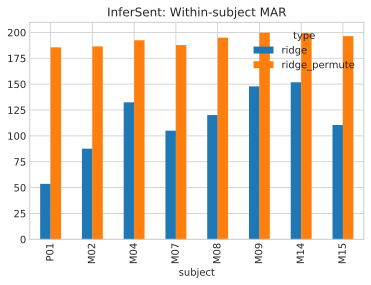

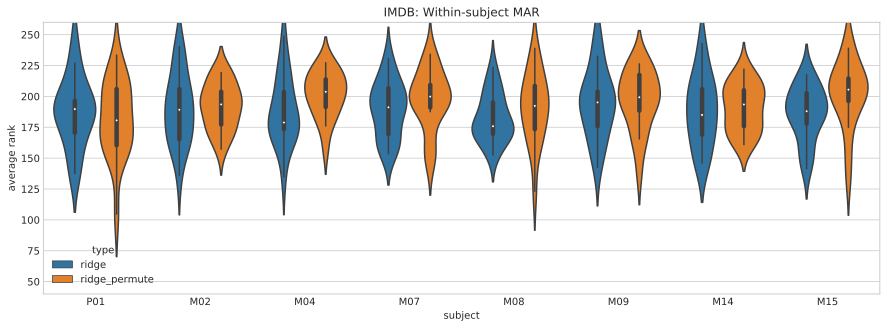

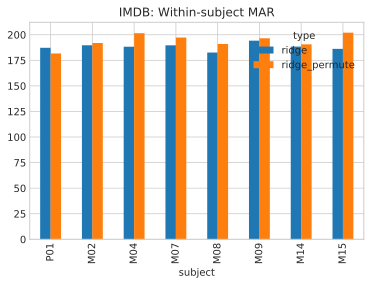

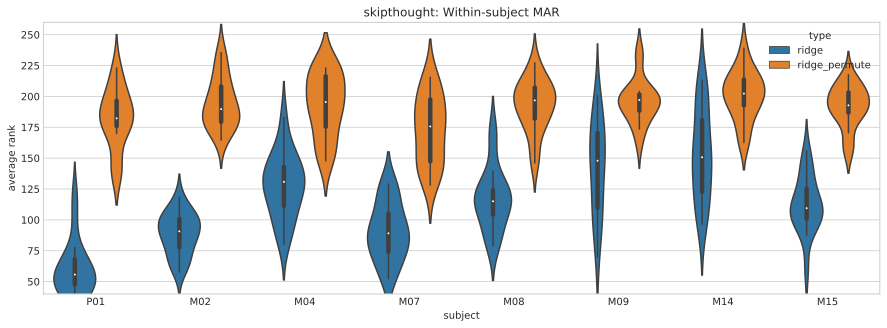

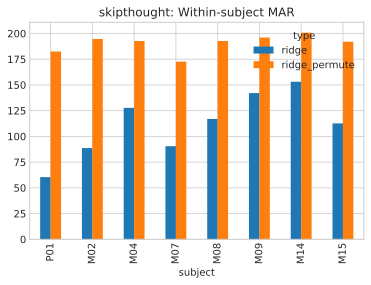

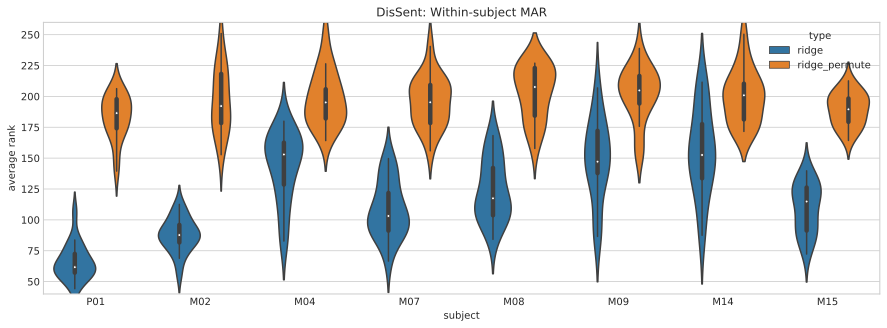

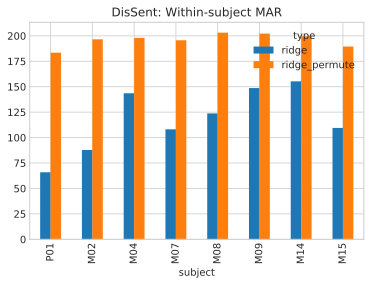

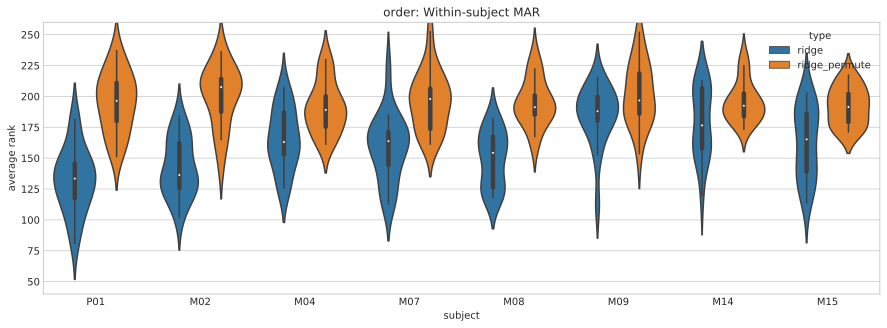

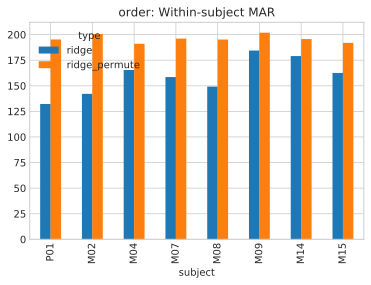

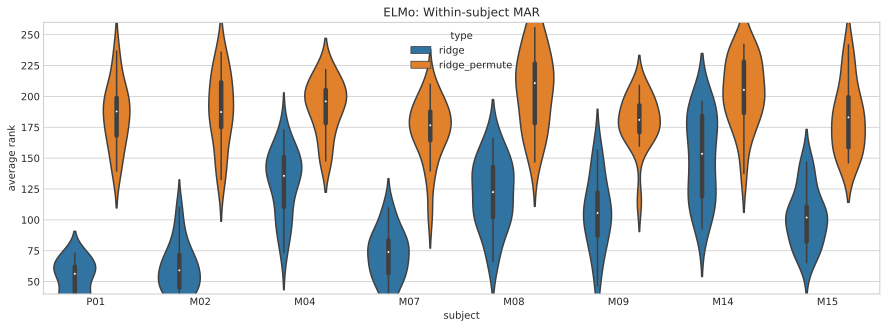

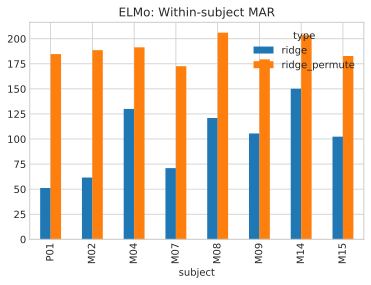

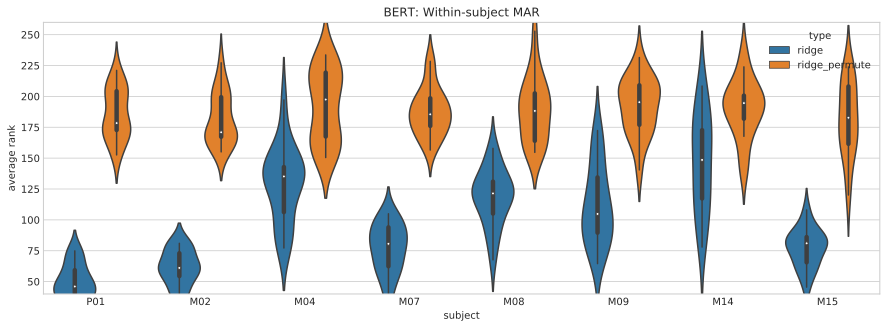

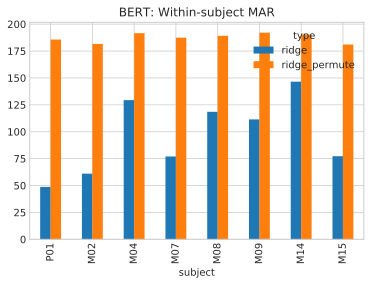

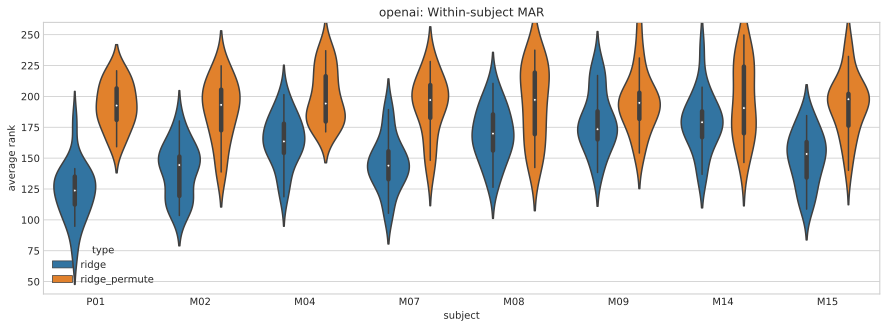

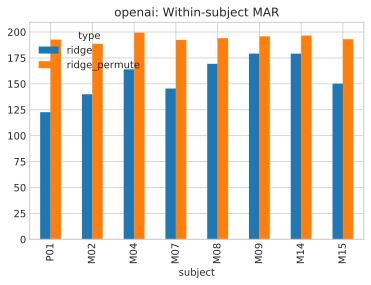

In [124]:
for model, path in models.items():
    try:
        stats[model] = analyze_encoding(model, "perf.384sentences.%s.csv" % path)
    except: pass

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [125]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [126]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [127]:
# Load full model predictions.
model_preds = {model: pd.read_csv("perf.384sentences.%s.pred.csv" % model_path).sort_index() for model, model_path in models.items()}

In [128]:
from scipy.stats import wilcoxon
import itertools

wilcoxon_results = []
for (model1_name, model1), (model2_name, model2) in itertools.combinations(model_preds.items(), 2):
    w_stat, p_val = wilcoxon(model1["rank"], model2["rank"])
    wilcoxon_results.append((model1_name, model2_name, w_stat, p_val))
    
wilcoxon_results = pd.DataFrame(wilcoxon_results, columns=["model1", "model2", "w_stat", "p_val"]).set_index(["model1", "model2"])
# Bonferroni correction
correction = len(list(itertools.combinations(model_preds.items(), 2)))
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val"] < 0.01 / correction

In [129]:
wilcoxon_results.sort_values("p_val")

w_stat          p_val  significant_bonferroni
model1      model2                                                       
IMDB        BERT          839406.5  2.429791e-198                    True
            ELMo          868804.5  1.136294e-188                    True
GloVe       IMDB          892941.0  2.341845e-183                    True
order       BERT          922699.0  2.070435e-175                    True
GloVe       order         952245.5  1.284556e-166                    True
order       ELMo          971158.5  6.677623e-162                    True
IMDB        skipthought  1038044.0  1.882929e-147                    True
InferSent   IMDB         1065291.5  4.096705e-141                    True
BERT        openai       1065172.5  4.236191e-140                    True
IMDB        DisSent      1122924.5  5.737856e-128                    True
ELMo        openai       1125915.5  2.585267e-127                    True
GloVe       openai       1139744.0  1.145306e-121                    True
skipthought order        1170450.5  9.208237e-116                    True
ConvS2S     BERT         1202119.0  3.043307e-108                    True
InferSent   order        1234380.0  9.337471e-104                    True
ConvS2S     ELMo         1276818.5   2.334640e-95                    True
skipthought openai       1338168.5   5.356521e-83                    True
DisSent     order        1373461.5   7.233738e-79                    True
InferSent   openai       1370018.0   2.790892e-77                    True
GloVe       ConvS2S      1375130.5   5.945633e-77                    True
ConvS2S     IMDB         1424327.0   2.147801e-70                    True
DisSent     openai       1447372.0   7.418249e-66                    True
ConvS2S     skipthought  1551407.5   1.742095e-49                    True
DisSent     BERT         1567720.0   1.576645e-46                    True
ConvS2S     InferSent    1623505.5   4.625928e-41                    True
DisSent     ELMo         1614009.0   4.872011e-39                    True
ConvS2S     DisSent      1636080.0   2.193660e-38                    True
InferSent   BERT         1674503.5   7.271635e-33                    True
GloVe       DisSent      1667149.5   9.700331e-33                    True
IMDB        openai       1741047.5   3.535178e-29                    True
skipthought BERT         1701563.5   1.544739e-28                    True
InferSent   ELMo         1712818.5   5.151623e-28                    True
GloVe       InferSent    1712886.5   1.173212e-25                    True
skipthought ELMo         1735716.0   1.732244e-25                    True
IMDB        order        1779611.0   3.034051e-25                    True
GloVe       skipthought  1782340.5   1.281889e-21                    True
ConvS2S     order        1829740.5   7.974331e-21                    True
            openai       1867258.5   6.398768e-17                    True
skipthought DisSent      2048563.0   3.007278e-05                    True
InferSent   DisSent      2058800.5   6.265683e-04                   False
GloVe       BERT         2077988.5   3.495713e-03                   False
            ELMo         2129423.5   7.307837e-02                   False
ELMo        BERT         2139082.0   8.729467e-02                   False
order       openai       2205438.0   2.057197e-01                   False
InferSent   skipthought  2174091.5   2.496404e-01                   False

---------

# Aggregate graphs

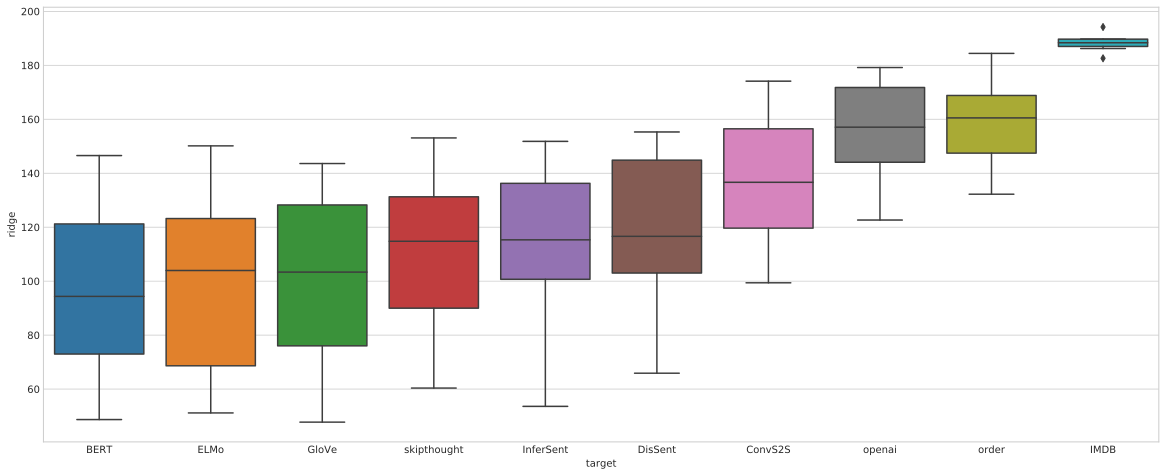

In [130]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [131]:
f.groupby("target").ridge.agg("mean")

target
BERT            96.226190
ConvS2S        137.184854
DisSent        117.817460
ELMo            99.097884
GloVe          100.315476
IMDB           188.308532
InferSent      113.621362
openai         156.229828
order          159.189815
skipthought    111.482804
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  8.6  0. ]


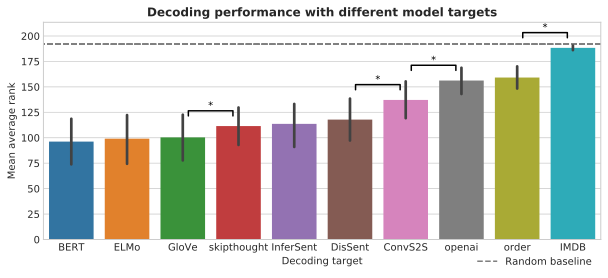

In [132]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.04))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
mean_results = f.groupby("target").ridge.agg("mean")
for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
    m1_label = m1_label.get_text()
    m2_label = m2_label.get_text()
    try:
        significant = wilcoxon_results.loc[m1_label, m2_label].significant_bonferroni
    except:
        significant = wilcoxon_results.loc[m2_label, m1_label].significant_bonferroni
    
    if significant:
        y = max(mean_results[m1_label], mean_results[m2_label]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)

Text(0.5,1,'Decoding performance between subjects')

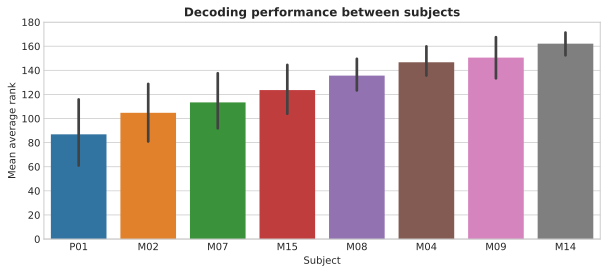

In [133]:
order = f.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")